In [76]:
import pandas as pd
# Here we load are data and calculate the average growth rate of vehicle sales from 2022 to 2023 by month,
# we find a crazy overall growth rate of 28.25% which we can guess is pent up post-pandemic demand. We better find a way to normalize growth
# A quick google search indicates that the Texas auto sales growth rate post covid was around 9% annually.

df = pd.read_parquet("../data/processed/vehicle_sales_model_ready_with_bestseller.parquet")
monthly_sales = df.groupby(['year', 'month', 'brand_model'])['current_month_sales'].first().reset_index()

print("Average growth rate 2022→2023 by month:")
for month in range(1, 13):
    total_2022 = monthly_sales[(monthly_sales['year'] == 2022) & (monthly_sales['month'] == month)]['current_month_sales'].sum()
    total_2023 = monthly_sales[(monthly_sales['year'] == 2023) & (monthly_sales['month'] == month)]['current_month_sales'].sum()
    growth = ((total_2023 / total_2022) - 1) * 100 if total_2022 > 0 else 0
    print(f"Month {month}: {growth:.1f}%")

Average growth rate 2022→2023 by month:
Month 1: 50.8%
Month 2: 29.7%
Month 3: 17.7%
Month 4: 6.9%
Month 5: 52.7%
Month 6: 48.6%
Month 7: 46.4%
Month 8: 10.5%
Month 9: 24.1%
Month 10: 19.2%
Month 11: 14.2%
Month 12: 18.2%


In [70]:
import pandas as pd
import numpy as np
import pickle
import warnings


warnings.filterwarnings('ignore')

# Load data and ML model
df = pd.read_parquet("../data/processed/vehicle_sales_model_ready_with_bestseller.parquet")
with open("../model/model.pkl", "rb") as f:
    model = pickle.load(f)

print(" 2024 Vehicle Sales Forecast (ML + Seasonal Patterns)")
print("=" * 60)

# Get monthly sales history
monthly_sales = df.groupby(['year', 'month', 'brand_model'])['current_month_sales'].first().reset_index()

# Calculate seasonal indices from 2022-2023 data
print("\n📊 Calculating seasonal patterns from 2022-2023 data...")
seasonal_indices = {}

for brand_model in monthly_sales['brand_model'].unique():
    model_data = monthly_sales[monthly_sales['brand_model'] == brand_model]
    
    # Need data from both years to calculate seasonal pattern
    data_2022 = model_data[model_data['year'] == 2022]
    data_2023 = model_data[model_data['year'] == 2023]
    
    if len(data_2022) >= 6 and len(data_2023) >= 6:  # Need sufficient data
        # Calculate average sales by month across both years
        monthly_avg = model_data.groupby('month')['current_month_sales'].mean()
        overall_avg = monthly_avg.mean()
        
        if overall_avg > 0:
            # Seasonal index = monthly average / overall average
            seasonal_indices[brand_model] = (monthly_avg / overall_avg).to_dict()

print(f"✓ Calculated seasonal patterns for {len(seasonal_indices)} models")

# Get latest features for ML prediction
latest_features = df.sort_values(['brand_model', 'year', 'month']).groupby('brand_model').last()

print("\n Using ML model to identify 2024 bestsellers...")

forecast_results = []

# For each month, use ML to find top 3, then apply seasonal patterns
for month in range(1, 13):
    # Create prediction dataset
    X_pred = []
    for brand_model in latest_features.index:
        row = latest_features.loc[brand_model].to_dict()
        row['brand_model'] = brand_model
        row['year'] = 2024
        row['month'] = month
        
        # Add rolling sales features
        model_history = monthly_sales[monthly_sales['brand_model'] == brand_model].tail(12)
        if len(model_history) > 0:
            recent_sales = model_history['current_month_sales'].values
            for i in range(1, 13):
                row[f'last_{i}_months_sales'] = recent_sales[-i:].sum() if len(recent_sales) >= i else recent_sales.sum()
        else:
            for i in range(1, 13):
                row[f'last_{i}_months_sales'] = 0
        
        X_pred.append(row)
    
    # Get ML predictions
    X_df = pd.DataFrame(X_pred)
    if 'monthly_best_seller' in X_df.columns:
        X_df = X_df.drop(columns=['monthly_best_seller'])
    
    probabilities = model.predict_proba(X_df)[:, 1]
    X_df['ml_probability'] = probabilities
    
    # Get top 3 by ML probability
    top3_ml = X_df.nlargest(3, 'ml_probability')
    
    month_name = pd.Timestamp(2024, month, 1).strftime('%B')
    print(f"\n{month_name} 2024:")
    
    for rank, (_, row) in enumerate(top3_ml.iterrows(), 1):
        brand_model = row['brand_model']
        
        # Get base sales (average of 2022-2023)
        model_sales = monthly_sales[monthly_sales['brand_model'] == brand_model]
        base_sales = model_sales['current_month_sales'].mean()
        
        # Apply seasonal pattern if available
        if brand_model in seasonal_indices and month in seasonal_indices[brand_model]:
            seasonal_factor = seasonal_indices[brand_model][month]
            forecast_sales = base_sales * seasonal_factor
        else:
            # If no seasonal pattern, use month-specific average
            month_sales = model_sales[model_sales['month'] == month]['current_month_sales']
            forecast_sales = month_sales.mean() if len(month_sales) > 0 else base_sales
        
        # Apply modest growth (9% from 2023 level)
        sales_2023 = model_sales[model_sales['year'] == 2023]['current_month_sales'].mean()
        if sales_2023 > 0 and not np.isnan(sales_2023):
            growth_factor = 1.09 * (base_sales / sales_2023)  # Adjusted growth
            forecast_sales = forecast_sales * growth_factor
        
        forecast_sales = int(max(1, forecast_sales))  # At least 1 unit
        
        print(f"  {rank}. {brand_model}: {forecast_sales} units (ML prob: {row['ml_probability']:.3f})")
        
        forecast_results.append({
            'year': 2024,
            'month': month,
            'rank': rank,
            'brand_model': brand_model,
            'ml_probability': row['ml_probability'],
            'forecast_units': forecast_sales,
            'has_seasonal_pattern': brand_model in seasonal_indices
        })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Summary
print("\n" + "=" * 60)
print("📈 FORECAST SUMMARY:")
total_forecast = forecast_df['forecast_units'].sum()
models_with_seasonal = forecast_df['has_seasonal_pattern'].sum()
print(f"  Total units forecasted: {total_forecast:,}")
print(f"  Predictions using seasonal patterns: {models_with_seasonal}/{len(forecast_df)}")

# Show seasonal variation
monthly_totals = forecast_df.groupby('month')['forecast_units'].sum()
print("\n📊 Monthly variation (showing seasonality):")
for month in range(1, 13):
    total = monthly_totals.get(month, 0)
    bar = '█' * int(total / 10)
    month_name = pd.Timestamp(2024, month, 1).strftime('%b')
    print(f"  {month_name}: {bar} {total}")

# Save results
forecast_df.to_csv('../output/ml_seasonal_forecast_2024.csv', index=False)
print("\nForecast saved to: ../output/ml_seasonal_forecast_2024.csv")

 2024 Vehicle Sales Forecast (ML + Seasonal Patterns)

📊 Calculating seasonal patterns from 2022-2023 data...
✓ Calculated seasonal patterns for 155 models

 Using ML model to identify 2024 bestsellers...

January 2024:
  1. Mercury-Grand Marquis: 6 units (ML prob: 1.000)
  2. Chevrolet-Malibu: 3 units (ML prob: 1.000)
  3. BMW-323i: 2 units (ML prob: 1.000)

February 2024:
  1. Mercury-Grand Marquis: 4 units (ML prob: 1.000)
  2. Chevrolet-Malibu: 6 units (ML prob: 1.000)
  3. BMW-323i: 4 units (ML prob: 1.000)

March 2024:
  1. Mercury-Grand Marquis: 10 units (ML prob: 1.000)
  2. Chevrolet-Malibu: 9 units (ML prob: 1.000)
  3. BMW-323i: 8 units (ML prob: 1.000)

April 2024:
  1. Mercury-Grand Marquis: 7 units (ML prob: 1.000)
  2. Chevrolet-Malibu: 6 units (ML prob: 1.000)
  3. Acura-TL: 6 units (ML prob: 1.000)

May 2024:
  1. Mercury-Grand Marquis: 12 units (ML prob: 1.000)
  2. Chevrolet-Malibu: 6 units (ML prob: 1.000)
  3. Acura-TL: 10 units (ML prob: 1.000)

June 2024:
  1. Me

In [78]:
#Let's put our existing data and our models predictions together to see how well we did
import pandas as pd

# Load actuals (2022-2023)
actuals = pd.read_parquet("../data/processed/vehicle_sales_model_ready_with_bestseller.parquet")
actuals = actuals[['year', 'month', 'brand_model', 'current_month_sales']]
actuals = actuals[(actuals['year'] >= 2022) & (actuals['year'] <= 2023)].copy()
actuals['type'] = 'Actual'
actuals.rename(columns={'current_month_sales': 'units'}, inplace=True)

# Load forecast (2024)
forecast = pd.read_csv("../output/ml_seasonal_forecast_2024.csv")
forecast = forecast[['year', 'month', 'brand_model', 'forecast_units']]
forecast['type'] = 'Forecast'
forecast.rename(columns={'forecast_units': 'units'}, inplace=True)

# Combine into one DataFrame
all_years = pd.concat([actuals, forecast], ignore_index=True)
all_years['date'] = pd.to_datetime(dict(year=all_years.year, month=all_years.month, day=1))

# Optional: sort for plotting
all_years = all_years.sort_values(['brand_model', 'date'])

# Now all_years contains 2022-2023 actuals and 2024 forecast, ready for plotting!

import pandas as pd




       year  month        brand_model  units      type       date
209    2022      1  Volkswagen-Passat      6    Actual 2022-01-01
210    2022      1  Volkswagen-Passat      6    Actual 2022-01-01
213    2022      1  Volkswagen-Passat      6    Actual 2022-01-01
272    2022      1  Volkswagen-Passat      6    Actual 2022-01-01
288    2022      1  Volkswagen-Passat      6    Actual 2022-01-01
...     ...    ...                ...    ...       ...        ...
23868  2023     12  Volkswagen-Passat     31    Actual 2023-12-01
23932  2024      9  Volkswagen-Passat     21  Forecast 2024-09-01
23935  2024     10  Volkswagen-Passat     16  Forecast 2024-10-01
23938  2024     11  Volkswagen-Passat     25  Forecast 2024-11-01
23941  2024     12  Volkswagen-Passat     25  Forecast 2024-12-01

[395 rows x 6 columns]


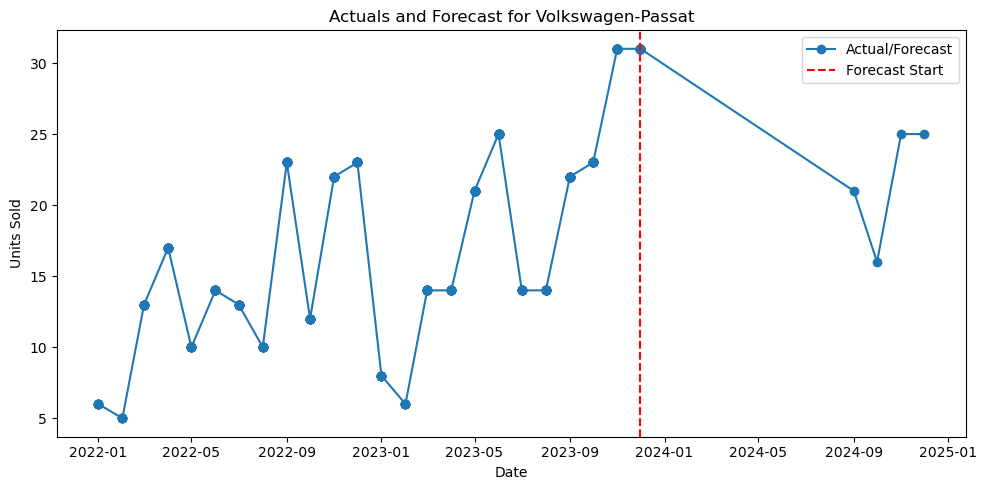

In [79]:


# Here let's check our problem model the Passat and we see how problematic it is to stop predicting at a threshold! 
# It makes your visualizations look bad and you miss out on the actuals!
model_name = "Volkswagen-Passat"

model_df = all_years[all_years['brand_model'] == model_name].copy()
print(model_df)

# Plot actuals and forecast for this model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(model_df['date'], model_df['units'], marker='o', label='Actual/Forecast')
plt.axvline(model_df[model_df['type'] == 'Actual']['date'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title(f"Actuals and Forecast for {model_name}")
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

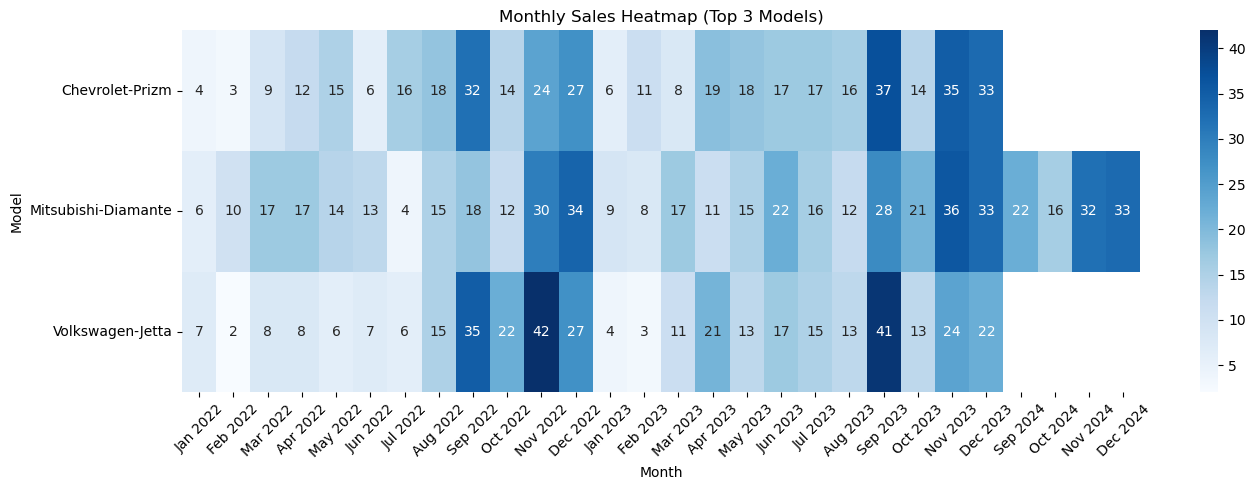

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 3 models by total sales
top_3_models = all_years.groupby('brand_model')['units'].sum().nlargest(3).index.tolist()

# Format the date columns as 'Mon YYYY' and filter for top 3
pivot = all_years[all_years['brand_model'].isin(top_3_models)].pivot_table(
    index='brand_model',
    columns='date',
    values='units',
    aggfunc='first'
)
pivot.columns = [col.strftime('%b %Y') for col in pivot.columns]  # Format columns

plt.figure(figsize=(14, 5))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='.0f')
plt.title('Monthly Sales Heatmap (Top 3 Models)')
plt.xlabel('Month')
plt.ylabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I feel like old school seasonal linear regression will work better than some fancy ML model. Let's check. 

In [87]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

# Load the pre-aggregated monthly counts
monthly_counts = pd.read_csv('../output/monthly_counts_by_model.csv')

print("🚗 2024 Vehicle Sales Forecast (Seasonal Linear Regression, using monthly counts)")
print("=" * 60)

# Create a time index (months since Jan 2022)
monthly_counts['time_index'] = (monthly_counts['year'] - 2022) * 12 + monthly_counts['month']

# Calculate seasonal indices from 2022-2023 data
print("\n📊 Calculating seasonal patterns from 2022-2023 data...")
seasonal_indices = {}
for brand_model in monthly_counts['brand_model'].unique():
    model_data = monthly_counts[monthly_counts['brand_model'] == brand_model]
    data_2022 = model_data[model_data['year'] == 2022]
    data_2023 = model_data[model_data['year'] == 2023]
    
    if len(data_2022) >= 6 and len(data_2023) >= 6:
        monthly_avg = model_data.groupby('month')['count'].mean()
        overall_avg = monthly_avg.mean()
        if overall_avg > 0:
            seasonal_indices[brand_model] = (monthly_avg / overall_avg).to_dict()

print(f"✓ Calculated seasonal patterns for {len(seasonal_indices)} models")

# Fit linear regression for each brand_model
print("\n📈 Fitting linear regression models...")
forecast_results = []
models_trained = 0

for brand_model in seasonal_indices.keys():
    model_data = monthly_counts[monthly_counts['brand_model'] == brand_model].dropna(subset=['count'])
    X = model_data[['time_index']].values
    y = model_data['count'].values

    if len(y) == 0:
        continue

    reg = LinearRegression()
    reg.fit(X, y)
    models_trained += 1

    # Forecast for 2024 (months 25 to 36, assuming Jan 2022 = 1)
    for month in range(1, 13):
        time_index = 24 + month  # Jan 2024 = 25, Dec 2024 = 36
        trend_sales = reg.predict([[time_index]])[0]
        seasonal_factor = seasonal_indices[brand_model].get(month, 1.0)
        forecast_sales = trend_sales * seasonal_factor

        # Apply modest growth (9% from 2023 average)
        sales_2023 = model_data[model_data['year'] == 2023]['count'].mean()
        if sales_2023 > 0 and not np.isnan(sales_2023):
            forecast_sales *= 1.09

        forecast_sales = int(max(1, forecast_sales))
        forecast_results.append({
            'year': 2024,
            'month': month,
            'brand_model': brand_model,
            'forecast_units': forecast_sales,
            'has_seasonal_pattern': True
        })

print(f"✓ Trained linear regression for {models_trained} models")

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Save results
forecast_df.to_csv('../output/seasonal_linear_regression_forecast_2024.csv', index=False)
print("\n✅ Forecast saved to: ../output/seasonal_linear_regression_forecast_2024.csv")

🚗 2024 Vehicle Sales Forecast (Seasonal Linear Regression, using monthly counts)

📊 Calculating seasonal patterns from 2022-2023 data...
✓ Calculated seasonal patterns for 155 models

📈 Fitting linear regression models...
✓ Trained linear regression for 155 models

✅ Forecast saved to: ../output/seasonal_linear_regression_forecast_2024.csv
